In [29]:
%matplotlib inline
import book_format
book_format.set_style()

# 需求分析
我们现在想用高斯分布来表示小车的位置, 我们假设的小车在10m的位置,它的方差为$1m^2$ , 我们用图形的方式表示如下:

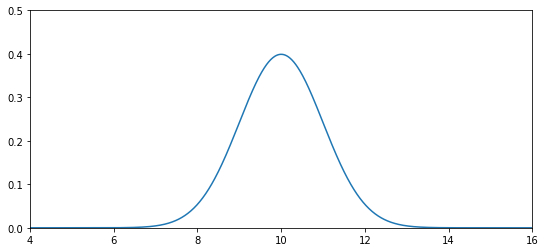

In [30]:
import filterpy.stats as stats

stats.plot_gaussian_pdf(mean=10,variance=1,xlim=(4,16),ylim=(0,0.5))

我们很确信的估计小车的位置在10m处,但是由于种种原因,我们可能的估计可能有些偏差,比如它当前出来的真实位置可能在9-11之间. 
怎么办呢? 我们可以借助一些测量工具, 再次对小车位置进行测量,例如测量出来的结果为10.2m, 这样提升了我们估计的准确度
假设我们用工具对小车当前位置进行500次的测量,每次测量的结果都在8-12之间,所有的数据都围绕着10m 那么我们对小车当前位置处在10m会更加有信心

下面我们用图形的形式,将刚才的这种猜想绘制出来看一下

9.995438231329622


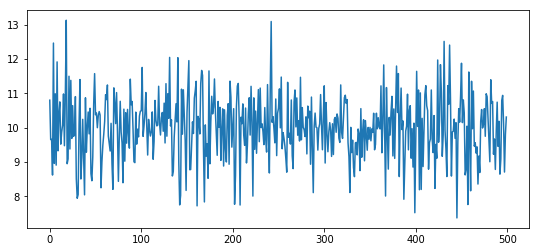

In [31]:
import numpy as np 
from numpy.random import randn
import matplotlib.pyplot as plt

xs = range(500)
ys = 10 + randn(500)

plt.plot(xs,ys)


print(np.mean(ys))


在真实情况下,小车不会像这样在10m位置附近不停的这样运动,但是我们的测量工具会出现这种情况,这就是噪声. 我们计算出来的均值结果已经非常接近10m, 假设小车一直没有动,我们可以说小车当前位置为10,方差为1

# 用高斯来预测
假设小车是在做匀速直线运动,我们想要预测小车的位置,我们可以根据当前速度和小车上一次的位置来进行预测:
    
$$ \begin{aligned}\bar{x}_k &= x_{k-1} + v_k \Delta t \\
 &= x_{k-1} + f_x\end{aligned}$$

如果上一次小车的位置为10m,速度位15m/s,那么2s之后小车的位置为:
    
$$ \begin{aligned} f_x &= v\Delta t = 15\cdot 2\\
\bar{x}_k &= 10 + (15\cdot 2) = 40 \end{aligned}$$

但是,正如我们前面所讲的,我们并不能确定小车当前的位置为10m,速度位15m/s. 我们需要将这种不确定性,通过高斯分布来进行描述.

假设我们用$x$来表示小车的位置,我们认为小车当前在10m,可能有0.2m的误差,我们就可以用$x =\mathcal N(10,0.2^2)$来表示,其中10表示均值,0.2表示标准差

同样的速度我们认为的值为15m/s,标准差为0.7m/s,那么这种速度的不确定性,我们就可以用$v = \mathcal N(15,0.7^2)$表示

假设小车运动的时间:$\Delta t = 1s$,那么套用上面的公式,我们可以算出小车的位置为:
$$\bar x = x + v*\Delta t$$

其中:
$$
x = \mathcal N(10,0.2^2) \\
v = \mathcal N(15,0.7^2) \\
\Delta t = 1s
$$

按照前面高斯函数的加法公式:
$$\begin{gathered}
\mu = \mu_1 + \mu_2 \\
\sigma^2 = \sigma^2_1 + \sigma^2_2
\end{gathered}$$

我们可以计算出当前的结果为:

$$\begin{aligned}\bar x &= \mu_x + \mu_{f_x} = 10 + 15 &&= 25 \\
\bar\sigma^2 &= \sigma_x^2 + \sigma_{f_x}^2 = 0.2^2 + 0.7^2 &&= 0.53\end{aligned}$$

通过上面的计算,我们似乎已经成功预测出来了小车当前的位置,而由于速度和位置我们都有点不确定,所以当前位置的不确定增大了($0.2^2 + 0.7^2$)


下面我们可以利用python代码的方式来实现上述过程:

In [32]:
from collections import namedtuple
# 创建有名称的元组
gaussian = namedtuple("Gaussian",["mean","var"])
gaussian.__repr__ = lambda s: "𝒩(μ={:.3f}, 𝜎²={:.3f})".format(s[0],s[1])

利用上面这个有名称的元组,我们来做测试

In [33]:
g1 = gaussian(10,0.2**2)
print(g1)
g2 = gaussian(15,0.7**2)
print(g2)

𝒩(μ=10.000, 𝜎²=0.040)
𝒩(μ=15.000, 𝜎²=0.490)


我们可以通过下面这些方式,访问它里面的属性

In [34]:
g1.mean,g1.var,g1[0],g1[1]

(10, 0.04000000000000001, 10, 0.04000000000000001)

下面我们就来实现一下预测的代码:

In [35]:
def predict(pos,vel):
    """
        pos : 位置的高斯分布
        vel : 速度高斯分布
    """
    mean = pos.mean + vel.mean
    var = pos.var + vel.var
    
    return gaussian(mean,var)

我们来预测一下$x = \mathcal N(10,0.2^2) ,v = \mathcal N(15,0.7^2)$的结果:

In [36]:
# 小车的位置 10, 0.2
pos = gaussian(10,0.2**2)
vel = gaussian(15,0.7**2)

predict(pos,vel)

𝒩(μ=25.000, 𝜎²=0.530)

这个就是我们通过手工的方式预测出来的结果

# 用高斯来更新
假设我们预测出来小车的位置为10m, 我们用测距仪测出小车离起点的位置为23m,购买的测距仪厂商有跟我们说误差为0.4m,那么小车当前最优可能的位置应该在哪呢?

大家还记得我们前面学过的高斯乘法吗?
$$\begin{aligned}
\mu &= \frac{\sigma_1^2 \mu_2 + \sigma_2^2 \mu_1} {\sigma_1^2 + \sigma_2^2}, \\
\sigma^2 &= \frac{\sigma_1^2\sigma_2^2}{\sigma_1^2+\sigma_2^2}
\end{aligned}$$

两个高斯函数相乘,结果的均值在两个均值之间,方差变小,概率越集中在均值附近. 在当前这个场景中,方差变小,意味着我们更加确信小车当前的位置

下面我们用代码的形式来实现高斯函数的乘法:

In [37]:
def gaussian_multiply(g1,g2):
    mean = (g1.var*g2.mean + g2.var*g1.mean)/(g1.var + g2.var)
    var = (g1.var*g2.var)/(g1.var + g2.var)
    
    return gaussian(mean,var)

def update(g1,g2):
    return gaussian_multiply(g1,g2)

# 1. 预测小车的位置
predict_pos = gaussian(10,0.2*2)
# 2. 假设这是小车测量的结果
measured_pos = gaussian(11,0.1**2)
# 3. 估计小车当前的位置
estimate_pos = update(predict_pos,measured_pos)

print(estimate_pos)

𝒩(μ=10.976, 𝜎²=0.010)


接下来,我们来重新复习一下高斯乘法.
假设我用同一把测距仪对小车当前距离起点的距离,进行测算,第一次我得出的结果为10m, 我觉得这个值不是很有把握,测距仪的说明书上说这东西有1m的误差.
我不太确定我刚才的结果,所以我对小车进行了二次测量,测量的结果还是10m  
由于测距仪存在误差1m,并且它们是符合高斯分布的,所以我们可以用高斯函数来表示上述两个结果:  
第一次: $\mathcal N(10,1)$  
第二次: $\mathcal N(10,1)$  
两次输出的结果都为10m,那么我们对小车在10m位置的自信度是不是就越高了啊!

大家可以猜一下,最终结果的图应该是涨什么样,均值是多少,方差又是多少?

我们用图标来描述一下我们刚才的过程吧!

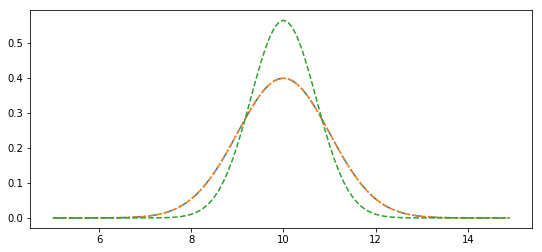

In [38]:
first = gaussian(10,1**2)
second = gaussian(10,1**2)

result = gaussian_multiply(first,second)

xs = np.arange(5,15,0.1)
#  绘制第一次的图像
ys = [stats.gaussian(x,first.mean,first.var) for x in xs]
plt.plot(xs,ys,label="$\mathcal {N}(10,1)$",ls="-.")

#  绘制第二次的图像
ys = [stats.gaussian(x,second.mean,second.var) for x in xs]
plt.plot(xs,ys,label="$\mathcal {N}(10,1)$",ls="--")

# 融合的结果
ys = [stats.gaussian(x,result.mean,result.var) for x in xs]
plt.plot(xs,ys,label="$\mathcal {N}(10,1) \\times \mathcal {N}(10,1)$",ls="--")

正如我们前面所描述的一样,两次结果都为10m,我们更加确信当前小车的位置就是10m,所以方差更小,波形越窄.  

上面我们描述的是一种比较理想的状态,两次测量出来的结果都为10m  

那假设第一次我们测量的结果为9.8m,因为误差的原因,我对这个结果不是很有信心,怎么办?  

进行第二次测量,测得结果为10.3m.  

由于我们使用的还是同一把测距仪,所以标准差仍然为1m.上面出来两个结果,小车不可能同时出现在两个位置,那小车最有可能的位置应该是多少呢?  

我们可以把上面这种不确定的测量结果写为高斯分布的形式:$$\mathcal N(9.8,1) 和 \mathcal N(10.3,1)$$

然后将他们相乘计算一下结果

接下来,我们用图表的形式来展示一下:

𝒩(μ=10.050, 𝜎²=0.500)


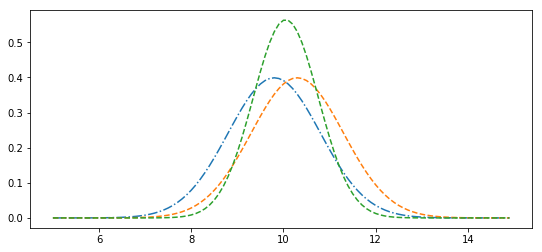

In [46]:
first = gaussian(9.8,1**2)
second = gaussian(10.3,1**2)

result = gaussian_multiply(first,second)

xs = np.arange(5,15,0.1)
#  绘制第一次的图像
ys = [stats.gaussian(x,first.mean,first.var) for x in xs]
plt.plot(xs,ys,label="$\mathcal {N}(10,1)$",ls="-.")

#  绘制第二次的图像
ys = [stats.gaussian(x,second.mean,second.var) for x in xs]
plt.plot(xs,ys,label="$\mathcal {N}(10,1)$",ls="--")

# 融合的结果
ys = [stats.gaussian(x,result.mean,result.var) for x in xs]
plt.plot(xs,ys,label="$\mathcal {N}(10,1) \\times \mathcal {N}(10,1)$",ls="--")

print(result)

这一次我们计算出来的结果仍然在两次测量结果的中间,并且又瘦又高. 我们对小车最有可能的位置10.05的信心比较高.

下面我们先来将我们上面用到的绘图函数进行封装,方便我们后面使用

融合的结果:𝒩(μ=10.050, 𝜎²=0.500)


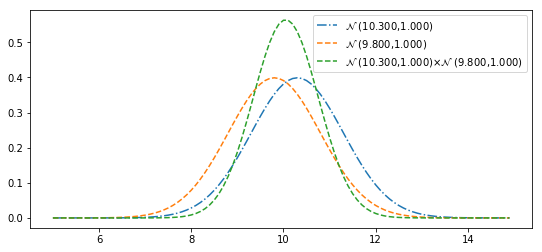

In [49]:
def plot_multiply(g1,g2):
    
    result = gaussian_multiply(g1,g2)
    
    plt.figure()
    xs = np.arange(5,15,0.1)
    #  绘制第一次的图像
    ys = [stats.gaussian(x,g1.mean,g1.var) for x in xs]
    plt.plot(xs,ys,label="$\mathcal {N}$ "+"({:.3f},{:.3f})".format(g1.mean,g1.var),ls="-.")

    #  绘制第二次的图像
    ys = [stats.gaussian(x,g2.mean,g2.var) for x in xs]
    plt.plot(xs,ys,label="$\mathcal {N}$ "+"({:.3f},{:.3f})".format(g2.mean,g2.var),ls="--")

    # 融合的结果
    ys = [stats.gaussian(x,result.mean,result.var) for x in xs]
    plt.plot(xs,ys,label="$\mathcal {N}$ "+"({:.3f},{:.3f})".format(g1.mean,g1.var)+"$ \\times \mathcal {N}$ "+"({:.3f},{:.3f})".format(g2.mean,g2.var),ls="--")
    plt.legend()
    print("融合的结果:{}".format(result))

z1 = gaussian(10.3,1)
z2 = gaussian(9.8,1)
    
plot_multiply(z1,z2)    

刚才我们用同一把测距仪测量了小车的位置. 
现在我们换另外一种情况来进行测量. 假设小米和华为都生产测距仪,并且我们手上各有一把.   
现在我们分别用它们进行测量,小米测出来的距离为9.7m, 华为测出来的距离为10.3米. 如果我们对这两家公司技术实力认可度相同的话,我们可能会认为小车当前最优可能的位置为:$(9.7 + 10.3)/2 = 10m$

但是我们仔细查阅说明书,发现小米载明的误差为:1m, 华为载明的误差为:1.5米. 那么按照这样的说明,我想我会相信小米的结果多一点, 华为的结果也是一个参考的结果.   
最有可能的结果肯定是在两者之间, 并且我更加相信它靠近小米结果一些.

下面我们用上面这种图示的方式来给大家展示一下,不同的方差对最终结果的一些影响:

融合的结果:𝒩(μ=9.940, 𝜎²=0.600)


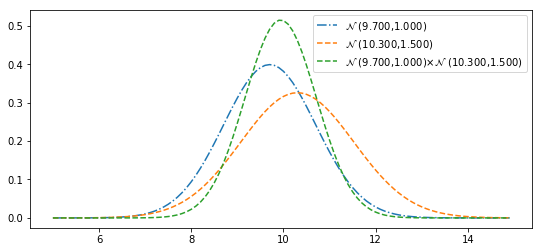

In [50]:
xiaomi = gaussian(9.7,1)
huawei = gaussian(10.3,1.5)

plot_multiply(xiaomi,huawei)

In [51]:
# 交互效果演示
from ipywidgets import interact

def interactive_gaussian(m1, m2, v1, v2):
    g1 = gaussian(m1, v1)
    g2 = gaussian(m2, v2)
    plot_multiply(g1, g2)
    
interact(interactive_gaussian,
         m1=(5, 10., .5), m2=(10, 15, .5), 
         v1=(.1, 2, .1), v2=(.1, 2, .1));

interactive(children=(FloatSlider(value=7.5, description='m1', max=10.0, min=5.0, step=0.5), FloatSlider(value…

# 第一个卡尔曼滤波案例
在本节中,我们来实现第一个卡尔曼滤波案例,前面我们已经实现了update()和predict()函数,  

现在我们其实只需要结合一些例子就可以慢慢理解卡尔曼滤波了.

我想预测小车当前最有可能的位置:

In [75]:
from itheima.Simulation import Car
np.random.seed(13)

# 定义小车初始的位置
x = gaussian(0,20**2)
velocity = 1
dt = 1

# 小车移动速度的方差
process_var = 1.0
# 测量的误差
sensor_var = 2.0

car = Car(x0=x.mean,velocity=velocity,measurement_var=sensor_var,process_var=process_var)

# 模拟运动10s的数据
zs = [car.move_and_sense() for _ in range(10)]

print(zs)

# 运动模型
process_model = gaussian(velocity*dt,process_var)




[1.3535959735108178, 1.8820653967131618, 4.341047429453569, 7.156332673205118, 6.938695089418526, 6.843912342028484, 9.846824080052299, 12.553482049375292, 16.2730841073834, 14.800411177015299]


下面就对数据进行卡尔曼滤波

In [76]:
print("卡尔曼滤波:1.预测,2.更新")

for z in zs:
    # 得到每一秒的测量结果
    measured_pos = gaussian(z,sensor_var)
    # 得到每一秒的预测结果
    predict_pos = predict(x,process_model)
    
    # 更新结果: 将预测的结果和测量的结果进行融合  x表示卡尔曼滤波输出的结果
    x = update(predict_pos,measured_pos)
    
    # 打印数据
    print("{:.3f}\t\t{:.3f}\t\t{:.3f}\t\t{:.3f}\t\t{:.3f}".format(predict_pos.mean,predict_pos.var,z,x.mean,x.var))

print("卡尔曼滤波最终的结果:",x.mean)
print("小车当前真实的位置:",car.x)

卡尔曼滤波:1.预测,2.更新
1.000		401.000		1.354		1.352		1.990
2.352		2.990		1.882		2.070		1.198
3.070		2.198		4.341		3.736		1.047
4.736		2.047		7.156		5.960		1.012
6.960		2.012		6.939		6.949		1.003
7.949		2.003		6.844		7.396		1.001
8.396		2.001		9.847		9.122		1.000
10.122		2.000		12.553		11.338		1.000
12.338		2.000		16.273		14.305		1.000
15.305		2.000		14.800		15.053		1.000
卡尔曼滤波最终的结果: 15.052894906364974
小车当前真实的位置: 14.838272007513229


# 卡尔曼增益
在上面的过程中,我们看到滤波的效果已经出来了,每一次估计的值都和测量的值进行了运算. 他们是两个高斯函数, 因此他们的均值公式如下:

$$
\mu=\frac{\bar\sigma^2\, \mu_z + \sigma_z^2 \, \bar\mu} {\bar\sigma^2 + \sigma_z^2}
$$

我们将公式稍作整理:  

$$\mu = \left( \frac{\bar\sigma^2}{\bar\sigma^2 + \sigma_z^2}\right) \mu_z + \left(\frac{\sigma_z^2}{\bar\sigma^2 + \sigma_z^2}\right)\bar\mu$$

我们再分别令$W_1 = \left( \frac{\bar\sigma^2}{\bar\sigma^2 + \sigma_z^2}\right)$ ,$W_2 = \left(\frac{\sigma_z^2}{\bar\sigma^2 + \sigma_z^2}\right)$

那么上面的式子我们就可以化简为:
$$\mu = W_1\mu_z + W_2\bar\mu$$

通过上面的公式,我们不难看出$W_1$ 和 $W_2$ 相当于预测结果和测量结果的权重,最终滤波的结果就是依赖于这两个权重. 

我们继续将上面的式子进一步的化简.令$K=W_1=\left( \frac{\bar\sigma^2}{\bar\sigma^2 + \sigma_z^2}\right)$ ,则
$$\begin{aligned}
W_2 &= \left(\frac{\sigma_z^2}{\bar\sigma^2 + \sigma_z^2}\right)\\
&= \left( \frac{\bar\sigma^2 + \sigma_z^2}{\bar\sigma^2 + \sigma_z^2}\right) - \left( \frac{\bar\sigma^2}{\bar\sigma^2 + \sigma_z^2}\right)\\ 
&= 1 - K
\end{aligned}$$

那么前面的公式我们可以进一步化简得到:
$$\begin{aligned}
\mu &= K\mu_z + (1-K)\bar\mu \\
&= \bar\mu + K(\mu_z - \bar\mu)
\end{aligned}$$

这里面的$K$其实就是卡尔曼滤波中非常重要的一个公式,卡尔曼增益:
$$K= \frac{\bar\sigma^2}{\bar\sigma^2 + \sigma_z^2}$$

我们可以把$K$卡尔曼增益,看做是在估计值$\bar\mu$和测量值$\mu_z$之间进行抉择的权重

下面我们来看个例子.假设测量值的方差为1($\sigma_z^2 = 1$),估计的方差为9($\bar\sigma^2 = 9$),则
$$\begin{aligned}
\mu&=\frac{9 \mu_z +  1\bar\mu} {9  + 1} \\
&= \left(\frac{9}{10}\right) \mu_z + \left(\frac{1}{10}\right) \bar\mu
\end{aligned}
$$

当前$K = \frac{9}{10}$ , 也就是说当估计值的方差较大,则测量值的权重越高, 反之,当估计值的方差较小,则估计值的权重更高.

下面我们在来看看当$\sigma_z^2 = \bar\sigma^2$ 时,  

$$\begin{gathered}
\mu=\frac{\sigma_z^2\,  (\bar\mu + \mu_z)}{2\sigma_\mathtt{z}^2} \\
= \left(\frac{1}{2}\right)\bar\mu + \left(\frac{1}{2}\right)\mu_z
\end{gathered}$$

我们可以看到,当估计值和测量值的方差相等的时候,实际上求的是两者的均值  

方差的结果我们也可以用卡尔曼增益来表示:
$$\begin{aligned}
\sigma^2 &= \frac{\bar\sigma^2 \sigma_z^2 } {\bar\sigma^2 + \sigma_z^2} \\
&= K\sigma_z^2 \\
&= (1-K)\bar\sigma^2 
\end{aligned}$$

通过上面的例子,我们其实可以认为卡尔曼增益$K$其实就是一个从测量值和估计值选取结果的缩放因子.

接下来,我们对我们前面所编写的predict()函数和update()函数重新整理

In [ ]:
def predict(g1,g2):
    # 前一次的位置和方差
    x,P = g1.mean,g1.var
    # 速度和方差
    dx,Q = g2.mean,g2.var
    # 预测当前位置
    x = x + dx
    # 更新方差
    P = P + Q
    return gaussian(x,P)

def update(prior,measurement):
    # 估计的均值和方差
    x,P = prior.mean,prior.var
    # 测量的均值和方差
    z,R = measurement.mean,measurement.var
    # 卡尔曼增益
    K = P/(P+R)
    # 计算融合的结果
    x = x + K*(z-x)
    # 计算融合的方差
    P = (1-K)*P
    
    return gaussian(x,P)

这两个函数,我们在前面已经实现过了,可能有同学很难理解为啥我要定义P,Q,R,K这些出来,这个其实很多书里面都是这样命名的,为了降低大家以后去看别人书的压力,我们也按照这种方式定义.下面我把这几个参数再次解释一下.

1. P: 预测的方差,这个值会在卡尔曼滤波的过程中更新
2. Q: 在预测时,系统产生的过程噪声. 例如我们并不准确知道小车当前速度
3. R: 测量噪声,通常情况下,测量设备不变,那么测量噪声的值也不会发生变化
4. K: 卡尔曼增益,这个很重要,它是我们在测量值和预测值之间进行取舍的缩放因子

卡尔曼滤波的过程其实就主要分为三部分:

**初始化**

    1. 初始预测物体的状态
    
**预测**

    1. 利用小车上一次的状态和运动模型,预测当前状态
    
**更新**

    1. 获取当前的预测值
    2. 获取当前的测量值
    3. 计算卡尔曼增益
    4. 利用卡尔曼增益,更新最新的状态
    5. 更新预测值的方差
    
下面用图表的形式来描述一下前面的这些过程:

<u>预测</u>

$\begin{array}{|l|l|l|}
\hline
\text{Equation} & \text{Implementation} & \text{Kalman Form}\\
\hline
 \bar x = x + f_x & \bar\mu = \mu + \mu_{f_x} & \bar x = x + dx\\
& \bar\sigma^2 = \sigma^2 + \sigma_{f_x}^2 & \bar P = P + Q\\
\hline
\end{array}$


<u>更新</u>

$\begin{array}{|l|l|l|}
\hline
\text{Equation} & \text{Implementation}& \text{Kalman Form}\\
\hline
 x = \| \mathcal L\bar x\| & y = z - \bar\mu & y = z - \bar x\\
 & K = \frac {\bar\sigma^2} {\bar\sigma^2 + \sigma_z^2} & K = \frac {\bar P}{\bar P+R}\\
 & \mu = \bar \mu + Ky & x = \bar x + Ky\\
 & \sigma^2 = \frac {\bar\sigma^2 \sigma_z^2} {\bar\sigma^2 + \sigma_z^2} & P = (1-K)\bar P\\
\hline
\end{array}$